<h1 style= "color:#9370DB;"> Stock Analysis </h1>

In [2]:
# 📚 Libraries 
import kagglehub
import pandas as pd
import numpy as np
import os

# New liabraries. 
import scipy.stats as st
import statsmodels.api as sm
import statsmodels.formula.api as smf

# 📊 Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as g

# 🤖 Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 

### The Stock Analysis Dataset:


**First impressions:**
    
_____________

The **S&P 500** is a stock market index tracking the performance of the largest 500 publicly traded companies listed on U.S. stock exchanges.

Investors have long used the S&P 500 as a benchmark for their investments as it tends to signal overall market health. 
The index is a popular choice for long-term inverstors who wish to watch growth over the coming deacades. 

The dataset contains: 
- S&P 500 **Index**: Contains the daily price of the index, representing the overall performance of the 500 companies in the S&P 500.
- S&P 500 **Stocks**: Includes the daily stock prices for each company within the index, providing insights into individual stock movements. 
- S&P 500 **Companies**: Provides detailed information about each company, including metrics such as Name, Sector, Marketcap, Ebitda, Weight.

The data types are even: (13 int or float / 13 objects).

Our **project goal** is to identify the performance of various sectors in the S&P 500. After reading the [documentation](https://www.kaggle.com/datasets/andrewmvd/sp-500-stocks) we will proceed with the following **strategy**:

1. The **target** of our dataset will be `currentprice`, which is the actual price of the stock right now.
2. Through **Exploratory Data Analysis** we will identify the features that contribute to this prediction.


_____________

<h2 style="color: #9370DB;"> 01 | Data Extraction </h2>

In [3]:
data = pd.read_csv('sp500_stocks.csv')
df = pd.read_csv('sp500_companies.csv')
sp = pd.read_csv('sp500_index.csv')

In [4]:
# Cleaning columns with snake_case 
data.columns = [col.lower().replace(" ", "_")for col in data.columns] 
df.columns = [col.lower().replace(" ", "_")for col in df.columns] 
sp.columns = [col.lower().replace(" ", "_")for col in sp.columns] 

<h3 style="color: #4169E1;">1.1 | Exploring the Data </h3>

In [5]:
data.sample(3)

,date,symbol,adj_close,close,high,low,open,volume
590908,2013-08-05,DTE,41.332310,60.468086,60.757446,60.255318,60.757446,763398.0
317214,2016-02-19,COF,55.917458,65.730003,65.879997,64.760002,65.500000,2456700.0
937345,2016-05-17,IR,NaN,NaN,NaN,NaN,NaN,NaN


### Dataset Description: 

A brief analysis of each column. 
- `Date`: The specific date for which the stock date is recorded. 
- `Symbol`: A unique "ticker" code that identifies the company on the stock exchange. 
- `Adj_close`: The closing price of the stock after adjustments for dividends, splits, or other corporate actions. 
- `Close`: The unadjusted closing price of the stock on a given date.  
- `High`: The highest price at which the stock traded during the day.  
- `Low`: The lowest price at which the stock traded during the day. 
- `Open`: The price at which the stock started trading at the beginning of the day.
- `Volume`: The total number of shares traded during the day.

In [6]:
df.sample(3)

,exchange,symbol,shortname,longname,sector,industry,currentprice,marketcap,ebitda,revenuegrowth,city,state,country,fulltimeemployees,longbusinesssummary,weight
155,NYQ,FDX,FedEx Corporation,FedEx Corporation,Industrials,Integrated Freight & Logistics,280.68,68576579584,1.088500e+10,0.139,Memphis,TN,United States,306000.0,"FedEx Corporation, together with its subsidiar...",0.001207
453,NYQ,CAG,"ConAgra Brands, Inc.","Conagra Brands, Inc.",Consumer Defensive,Packaged Foods,27.24,13000915968,2.239500e+09,-0.038,Chicago,IL,United States,18500.0,"Conagra Brands, Inc., together with its subsid...",0.000229
434,NYQ,AMCR,Amcor plc,Amcor plc,Consumer Cyclical,Packaging & Containers,10.18,14713562112,1.904000e+09,-0.026,Zurich,NaN,Switzerland,41000.0,"Amcor plc develops, produces, and sells packag...",0.000259


### Dataset Description: 

A brief analysis of each column: 
- `Exchange`: A marketplace where stocks, bonds or other comodities are traded. (Example: NYSE, NASDAQ).
- `Symbol`: A unique "ticker" code that identifies the company on the stock exchange. 
- `Shortname`: The abbreviated name of the company. 
- `Longname`: The full name of the company. 
- `Sector`: The broader industry classification that the company belongs to, such as Technology, Healthcare, etc. 
- `Industry`: A more specific classification of the company's operations (e.g., Software, Pharmaceuticals).
- `Currentprice`: The most recent price at which the company's stock was sold or bought. 
- `Marketprice`: The total market value of the company's outstanding shares, calculated as: Current Price X Outstanding Shares. 
- `Ebitda`: (Earnings Before Interest Taxes Depreciation and Amortization ) Measures how profitable a company is before paying interest, taxes, and taking depreciation and amortization. 
- `Revenuegrowth`: The percentage increase or decrease in sales between periods, calculated as: 
- `City`: The city where the company's headquarters is located. 
- `State`: The state where the company's headquarters is located.
- `Country`: The country of the company's origin. 
- `Fulltimeemployees`: The total number of employes of the company's business activities. 
- `Longbusinesssummary`: A breif description and overview of the company's business activities. 
- `Weight`: Represents the weight of the company's market cap relative to the total market cap, used in index calculations in the S&P 500. 


In [7]:
sp.sample(3)

,date,s&p500
1664,2021-07-20,4323.06
1004,2018-12-03,2790.37
247,2015-12-01,2102.63


### Dataset Description: 

A brief analysis of each colunn: 

- `Date`: The specific date for which the S&P 500 date is recorded. 
- `s&p500`: The closing price of the S&P 500 on a given date.  

<h3 style="color: #4169E1;">1.2 | Copies</h3>

In [8]:
data2 = data.copy()
df2 = df.copy()
sp2 = sp.copy()

<h2 style="color: #9370DB;"> 02 | ⚒️ Data Cleaning </h2>

<h3 style="color: #4169E1;"> 2.1 | Dealing with Data types</h3>

In [9]:
data.dtypes

date          object
symbol        object
adj_close    float64
close        float64
high         float64
low          float64
open         float64
volume       float64
dtype: object

In [10]:
df.dtypes

exchange                object
symbol                  object
shortname               object
longname                object
sector                  object
industry                object
currentprice           float64
marketcap                int64
ebitda                 float64
revenuegrowth          float64
city                    object
state                   object
country                 object
fulltimeemployees      float64
longbusinesssummary     object
weight                 float64
dtype: object

In [11]:
sp.dtypes

date       object
s&p500    float64
dtype: object

<h3 style="color: #4169E1;"> 2.2 | Dealing with NaN values</h3>

In [12]:
df.isna().sum()

exchange                0
symbol                  0
shortname               0
longname                0
sector                  0
industry                0
currentprice            0
marketcap               0
ebitda                 29
revenuegrowth           3
city                    0
state                  20
country                 0
fulltimeemployees       9
longbusinesssummary     0
weight                  0
dtype: int64

In [13]:
sp.isna().sum()

date      0
s&p500    0
dtype: int64

In [14]:
data.isna().sum()

date              0
symbol            0
adj_close    101626
close        101626
high         101626
low          101626
open         101626
volume       101626
dtype: int64

In [17]:
# Delete NaN. TELL WHY I'M dropping 
data2.dropna(how='any', inplace=True)

In [18]:
data2.isna().sum()

date         0
symbol       0
adj_close    0
close        0
high         0
low          0
open         0
volume       0
dtype: int64

In [20]:
# Use this as a reference conunting the same after dropping them that without droping them. 
data2.symbol.value_counts()

symbol
MMM     3758
MHK     3758
NTAP    3758
NDAQ    3758
MSCI    3758
        ... 
VLTO     297
SOLV     175
GEV      175
SW       108
AMTM      53
Name: count, Length: 503, dtype: int64

**Handling Missing Data:**

The dataset contains significant missing values (**NaN**) in critical columns such as `adj_close`, `close`, `high`, `low`, `open`, and `volume`. These columns are essential for stock market analysis since they represent key price and volume data. Rows with missing values were dropped using how='any' because incomplete data in these columns could lead to inaccurate insights or errors in further analysis or modeling.

<h3 style="color: #4169E1;"> 2.3 | Dealing with Duplicates</h3>

In [21]:
data2.duplicated().sum()

0

In [22]:
df.duplicated().sum()

0

In [23]:
sp.duplicated().sum()

0

<h3 style="color: #4169E1;"> 2.5 | Dealing with columns </h3>

In [25]:
# Delete Columns 
data2.drop(columns=['high', 'low', 'open','close'], inplace=True)

In [26]:
# Change to datetime from stocks. 
data2['date'] = pd.to_datetime(data2['date'])
# Change to datetime. SP 500. 
sp['date'] = pd.to_datetime(sp['date'])

In [27]:
data2['year'] = data2['date'].dt.year
data2['month'] = data2['date'].dt.month
data2['day'] = data2['date'].dt.day
sp['year'] = sp['date'].dt.year
sp['month'] = sp['date'].dt.month
sp['day'] = sp['date'].dt.day

In [28]:
cols = ['year', 'month', 'day', 'symbol', 'adj_close', 'volume']
data2 = data2[cols]
data2.head(3)

,year,month,day,symbol,adj_close,volume
0,2010,1,4,MMM,43.783867,3640265.0
1,2010,1,5,MMM,43.509628,3405012.0
2,2010,1,6,MMM,44.126682,6301126.0


In [29]:
# Drop rows where year is between 2010 and 2013 because SP500 for comparison we do have 2014. 
data2.drop(data2[(data2['year'] >= 2010) & (data2['year'] <= 2014)].index, inplace=True)
# Drop row for sp 500 as we do not have many. 
sp.drop(sp[sp['year'] == 2014].index, inplace=True)

/var/folders/bs/hzz4qdm57z9cct0t_9rdynfr0000gn/T/ipykernel_1627/1019899634.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2.drop(data2[(data2['year'] >= 2010) & (data2['year'] <= 2014)].index, inplace=True)


In [30]:
# Change columns for SP500. 
cols = ['year', 'month', 'day', 's&p500']
sp = sp[cols]
sp.head(3)

,year,month,day,s&p500
17,2015,1,2,2058.20
18,2015,1,5,2020.58
19,2015,1,6,2002.61


In [31]:
# Creating new columns. Which will give us the annual return yearly per each stock & sp500. 
annual_returns = data2.groupby(['symbol', 'year']).apply(lambda group: (group['adj_close'].iloc[-1] / group['adj_close'].iloc[0]) - 1).reset_index(name='annual_return').round(4)
annual_returns_sp = sp.groupby('year').apply(lambda group: (group['s&p500'].iloc[-1] / group['s&p500'].iloc[0]) - 1).reset_index(name='annual_return').round(4)
annual_returns_sp['symbol'] = 'SP500'

/var/folders/bs/hzz4qdm57z9cct0t_9rdynfr0000gn/T/ipykernel_1627/1891848652.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  annual_returns = data2.groupby(['symbol', 'year']).apply(lambda group: (group['adj_close'].iloc[-1] / group['adj_close'].iloc[0]) - 1).reset_index(name='annual_return').round(4)
/var/folders/bs/hzz4qdm57z9cct0t_9rdynfr0000gn/T/ipykernel_1627/1891848652.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to si

In [32]:
cols = ['symbol', 'year', 'annual_return']
annual_returns_sp = annual_returns_sp[cols]

In [33]:
pivoted_df = annual_returns.pivot(index='symbol', columns='year', values='annual_return')
pivoted_sp = annual_returns_sp.pivot(index='symbol',columns='year', values='annual_return')

In [36]:
# Unification from annual return from each stock adding the sp500. 
defi = pd.concat([pivoted_df,pivoted_sp], axis=0)
definitive = pd.merge (df2, pivoted_df, on='symbol')

In [40]:
definitive = definitive.rename(columns={2015: 'ar_2015',2016:'ar_2016',2017: 'ar_2017', 
                                          2018:'ar_2018', 2019: 'ar_2019',2020: 'ar_2020', 2021: 'ar_2021', 2022:'ar_2022', 2023:'ar_2023',2024: 'ar_2024'})

<h3 style="color: #4169E1;"> 2.6 | Moving target to the right </h3>

In [42]:
#Dropping Columns: Exchange, longname, longbusinesssumary. 
cols = ['symbol', 'shortname','sector','industry',
        'marketcap','ebitda', 'revenuegrowth', 'city', 'state', 'country',   
        'fulltimeemployees', 'weight', 'ar_2015', 'ar_2016', 'ar_2017', 'ar_2018', 'ar_2019',
        'ar_2020', 'ar_2021', 'ar_2022', 'ar_2023', 'ar_2024', 'currentprice']

In [43]:
definitive = definitive[cols]

In [45]:
definitive.head(4)

,symbol,shortname,sector,industry,marketcap,ebitda,revenuegrowth,city,state,country,...,ar_2016,ar_2017,ar_2018,ar_2019,ar_2020,ar_2021,ar_2022,ar_2023,ar_2024,currentprice
0,AAPL,Apple Inc.,Technology,Consumer Electronics,3670720643072,1.346610e+11,0.061,Cupertino,CA,United States,...,0.1238,0.4804,-0.0705,0.8874,0.7824,0.3806,-0.2820,0.5480,0.3145,242.84
1,NVDA,NVIDIA Corporation,Technology,Semiconductors,3488355713024,6.118400e+10,1.224,Santa Clara,CA,United States,...,2.3292,0.9043,-0.3285,0.7341,1.1802,1.2448,-0.5144,2.4610,1.9580,142.44
2,MSFT,Microsoft Corporation,Technology,Software - Infrastructure,3297889746944,1.365520e+11,0.160,Redmond,WA,United States,...,0.1651,0.3974,0.2022,0.5826,0.3994,0.5579,-0.2769,0.5835,0.2050,443.57
3,AMZN,"Amazon.com, Inc.",Consumer Cyclical,Internet Retail,2387220627456,1.115830e+11,0.110,Seattle,WA,United States,...,0.1772,0.5517,0.2632,0.2006,0.7160,0.0464,-0.5071,0.7704,0.5142,227.03


# <h2 style="color: #9370DB;"> 03 | EDA (Exploratory Data Analysis) </h2>

<h3 style="color: #4169E1;">3.1 | Descriptive Statistics </h3>

In [46]:
# Selecting categorical columns. 
cat = definitive.select_dtypes(exclude='number')
cat.head(5)

,symbol,shortname,sector,industry,city,state,country
0,AAPL,Apple Inc.,Technology,Consumer Electronics,Cupertino,CA,United States
1,NVDA,NVIDIA Corporation,Technology,Semiconductors,Santa Clara,CA,United States
2,MSFT,Microsoft Corporation,Technology,Software - Infrastructure,Redmond,WA,United States
3,AMZN,"Amazon.com, Inc.",Consumer Cyclical,Internet Retail,Seattle,WA,United States
4,GOOG,Alphabet Inc.,Communication Services,Internet Content & Information,Mountain View,CA,United States


In [47]:
# Selecting numerical columns. 
num = definitive.select_dtypes(include='number')
num.head(5)

,marketcap,ebitda,revenuegrowth,fulltimeemployees,weight,ar_2015,ar_2016,ar_2017,ar_2018,ar_2019,ar_2020,ar_2021,ar_2022,ar_2023,ar_2024,currentprice
0,3670720643072,1.346610e+11,0.061,164000.0,0.064589,-0.0208,0.1238,0.4804,-0.0705,0.8874,0.7824,0.3806,-0.2820,0.5480,0.3145,242.84
1,3488355713024,6.118400e+10,1.224,29600.0,0.061381,0.6645,2.3292,0.9043,-0.3285,0.7341,1.1802,1.2448,-0.5144,2.4610,1.9580,142.44
2,3297889746944,1.365520e+11,0.160,228000.0,0.058029,0.2188,0.1651,0.3974,0.2022,0.5826,0.3994,0.5579,-0.2769,0.5835,0.2050,443.57
3,2387220627456,1.115830e+11,0.110,1551000.0,0.042005,1.1907,0.1772,0.5517,0.2632,0.2006,0.7160,0.0464,-0.5071,0.7704,0.5142,227.03
4,2149065949184,1.234700e+11,0.151,181269.0,0.037815,0.4500,0.0404,0.3311,-0.0276,0.2784,0.2812,0.6743,-0.3884,0.5711,0.2646,176.49


In [48]:
definitive.describe()

,marketcap,ebitda,revenuegrowth,fulltimeemployees,weight,ar_2015,ar_2016,ar_2017,ar_2018,ar_2019,ar_2020,ar_2021,ar_2022,ar_2023,ar_2024,currentprice
count,5.030000e+02,4.740000e+02,500.000000,4.940000e+02,503.000000,475.000000,480.000000,482.000000,485.000000,491.000000,495.000000,495.000000,497.000000,499.000000,503.000000,503.000000
mean,1.129853e+11,7.031397e+09,0.070484,5.774496e+04,0.001988,0.045306,0.197734,0.258852,-0.034976,0.352786,0.192008,0.328778,-0.085353,0.195019,0.215239,230.293300
std,3.399129e+11,1.622777e+10,0.180071,1.394693e+05,0.005981,0.253423,0.277769,0.260448,0.225112,0.317066,0.548745,0.295113,0.279833,0.356690,0.382605,521.997583
min,5.637307e+09,-3.991000e+09,-0.602000,2.800000e+01,0.000099,-0.753000,-0.710600,-0.430800,-0.576200,-0.543300,-0.580300,-0.350500,-0.710700,-0.480700,-0.652500,8.560000
25%,2.036663e+10,1.623194e+09,0.002000,1.020000e+04,0.000358,-0.107050,0.047800,0.094325,-0.192900,0.185550,-0.051000,0.131250,-0.266900,-0.028700,0.004500,71.545000
50%,3.803281e+10,2.941705e+09,0.050000,2.159500e+04,0.000669,0.040700,0.177950,0.223250,-0.037800,0.328700,0.123900,0.306900,-0.114600,0.127500,0.167400,126.820000
75%,8.419720e+10,6.017250e+09,0.109000,5.476225e+04,0.001482,0.177300,0.310375,0.386175,0.093100,0.478200,0.302250,0.472350,0.057700,0.324050,0.371450,239.190000
max,3.670721e+12,1.495470e+11,1.632000,2.100000e+06,0.064589,1.722800,3.093900,1.427200,1.065900,4.311000,7.200500,1.900200,1.071300,2.461000,3.604300,8946.330000


In [50]:
definitive['currentprice'].describe()

count     503.000000
mean      230.293300
std       521.997583
min         8.560000
25%        71.545000
50%       126.820000
75%       239.190000
max      8946.330000
Name: currentprice, dtype: float64

<h3 style="color: #4169E1;"> 3.2 | Univariate Analysis </h3>

**Insights** from Summary Statistics for 'SalePrice':

- The average (mean) sale price of the houses in the dataset is approximately `$180.921`.

- The median sale price (middle value when sorted) stands at `$163.000`. Notably, the median is lower than the mean, suggesting a skew in the distribution of sale prices towards higher values.

- The standard deviation, a measure of the amount of variation or dispersion in the sale prices, is approximately `$79.442`. This indicates that sale prices can vary significantly from the average.

- The minimum and maximum sale prices are `$34.900` and `$755.000`, respectively, highlighting a wide range of property values in the dataset.

- The interquartile range (IQR), given by the values at 25% (Q1) and 75% (Q3), is between `$129.975` and `$214.000`. This means that 50% of the houses in the dataset were sold within this price range.

In [51]:
frequency_table = cat.sector.value_counts()
proportion_table = cat.sector.value_counts(normalize=True)

In [52]:
frequency_proportion = pd.concat([frequency_table,proportion_table], axis = 1)
frequency_proportion.columns = ['absolute_frequency', 'relative_frequency']

In [53]:
total_absolute = frequency_table.sum()
total_relative = proportion_table.sum()


In [54]:
total_row = pd.DataFrame({
    'absolute_frequency': [total_absolute],
    'relative_frequency': [total_relative]
}, index=['Total'])

In [55]:
df3 = pd.concat([frequency_proportion, total_row])
df3

,absolute_frequency,relative_frequency
Technology,82,0.163022
Industrials,70,0.139165
Financial Services,67,0.133201
Healthcare,63,0.125249
Consumer Cyclical,55,0.109344
Consumer Defensive,37,0.073559
Utilities,32,0.063618
Real Estate,31,0.061630
Communication Services,22,0.043738
Energy,22,0.043738


/var/folders/bs/hzz4qdm57z9cct0t_9rdynfr0000gn/T/ipykernel_1627/3055570902.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


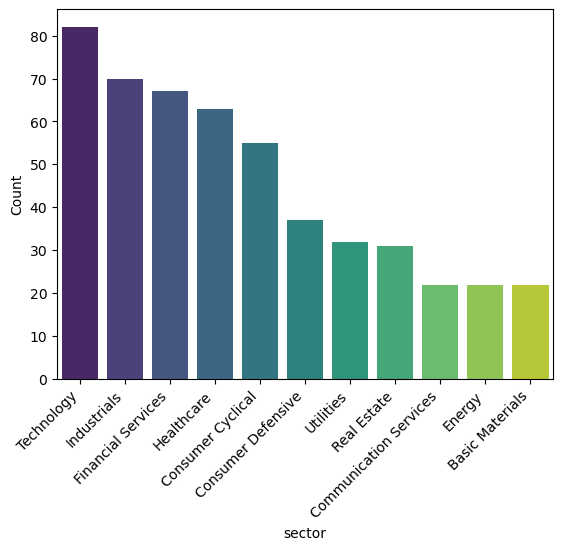

In [56]:
sns.barplot(
    x='sector',
    y='absolute_frequency',
    data=frequency_proportion,
    palette='viridis',
)
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

The frequency table gives the count of each sector, while the proportion table provides the percentage representation of each category in the dataset. This helps to quickly identify dominant and minority categories. Such as:
- Technology: 16% 
- Industrials: 14% 
- Financial Services: 13% 
- Healthcare: 12% 
- Consumer Cyclical: 10% 

In [57]:
definitive['currentprice'].describe()

count     503.000000
mean      230.293300
std       521.997583
min         8.560000
25%        71.545000
50%       126.820000
75%       239.190000
max      8946.330000
Name: currentprice, dtype: float64

**Insights** from Summary Statistics for `currentprice`:

- The average (**mean**) sale price of the stock in the dataset is approximately **$230.29**. This represents the central tendency of the prices.

- The **median** sale price is **$126.82**. Notably, the median is significantly lower than the mean, suggesting that the distribution of stock prices is skewed towards higher values (positively-skewed).

- The **standard deviation**, which measures the variation or spread of prices, is **$521.99**. This large value indicates a high level of variability in stock prices, suggesting that prices are widely dispersed from the mean.

- The **minimum** and **maximum** prices are **$8.56** and **$8946.33**, respectively. This extreme range highlights that the dataset includes stocks with both very low and very high prices.

- The **interquartile range (IQR)**, representing the middle 50% of the prices, lies between $71.54 (Q1) and $239.19 (Q3). This means that 50% of the stock prices fall within this range, providing a clearer picture of the typical stock price distribution without being influenced by outliers.

**Additional Note:**
The significant difference between the mean and median, combined with the large standard deviation, suggests the presence of outliers or high-value stocks that push the mean upwards. This highlights the importance of focusing on the IQR for understanding the core stock price range.

In [64]:
definitive.currentprice.skew().round(2)

11.81

In [65]:

definitive.currentprice.kurtosis().round(2)

174.88

(0.0, 2100.0)

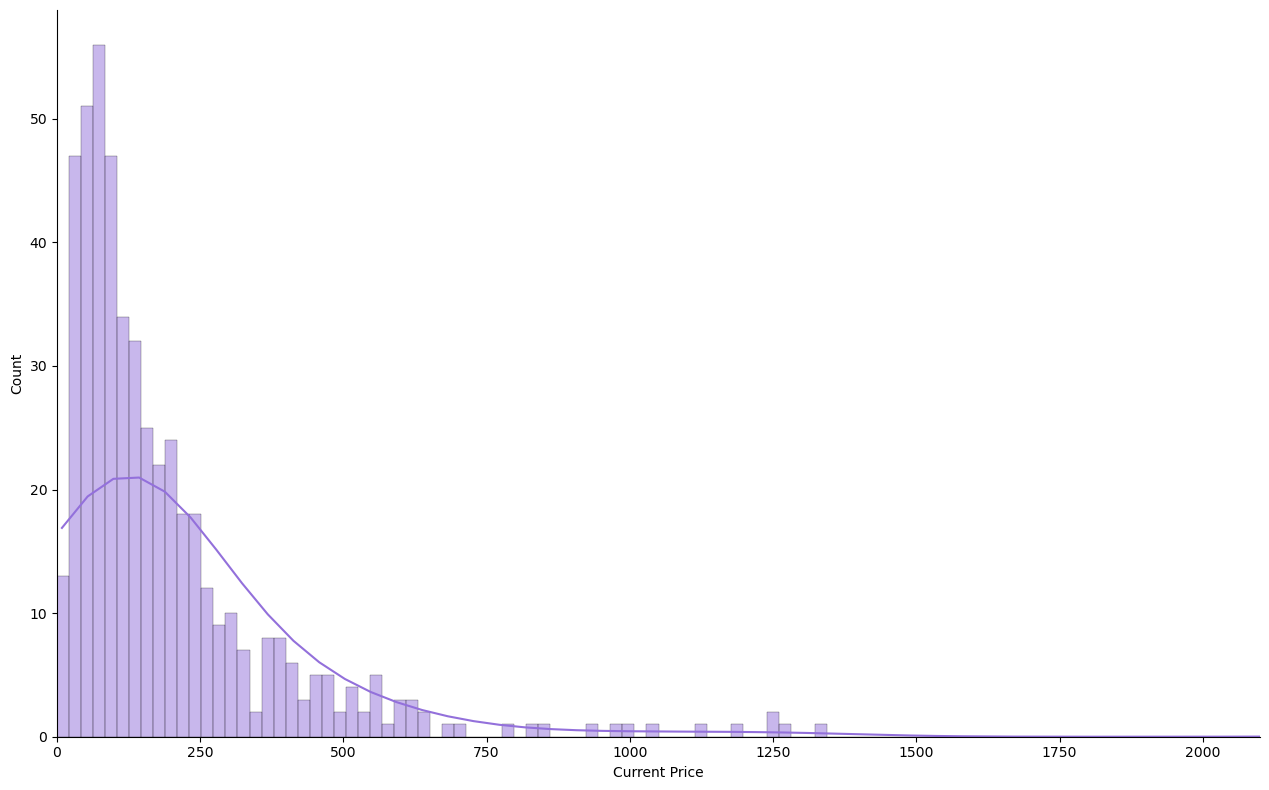

In [62]:
d2 = sns.displot(data=definitive, x='currentprice', kde=True, height=8, aspect=1.6, bins=100, binrange=(0, 2100), color='mediumpurple')
d2.set(xlabel='Current Price')
plt.xlim(0, 2100)

- Skewness of `currentprice`: \(11.81\)
- Kurtosis of `currentprice`: \(174.88\)

**Insights**:

1. **Skewness**: The positive value of skewness 11.81 for the 'currentprice' indicates that the distribution is right-skewed. This means that the tail on the right side (higher prices) is longer than the left side (lower prices). In practical terms, this suggests that there are a significant number of stocks that have higher prices, which are acting as outliers and pulling the mean upwards.
  
2. **Kurtosis**: The kurtosis value of 174.88 indicates that the 'currentprice' distribution has heavier tails and a sharper peak compared to a normal distribution. This means that there are more outliers (extreme values) in the 'currentprice' than one would expect in a normally distributed set.

In [ ]:
# Found out in Kaggle related notebooks. 
f = {'revenuegrowth':['mean'], 'marketcap':['sum'], 'shortname':['count']}

sector_breakdown = definitive.groupby('sector').agg(f)
sector_breakdown.columns = sector_breakdown.columns.get_level_values(0)
sector_breakdown = sector_breakdown.reset_index()
sector_breakdown = sector_breakdown.sort_values('shortname', ascending=False)

fig = plt.figure(num=None, figsize=(12, 6), dpi=100, facecolor='w', edgecolor='k')

plt.subplot(1, 3, 1)
ax1 = sns.barplot(x="shortname", y="sector", data=sector_breakdown, palette=('coolwarm'))
ax1.set_xlabel('Number of companies', weight='bold')
ax1.set_ylabel('sector', weight = 'bold')
ax1.set_title('SECTOR BREAKDOWN\n', weight='bold').set_fontsize('18')

plt.subplot(1, 3, 2)
ax2 = sns.barplot(x="marketcap", y="sector", data=sector_breakdown, palette=('Wistia'))
ax2.set_xlabel('Total Market Cap', weight='bold')
ax2.set_ylabel('')
ax2.set_yticks([])

plt.subplot(1, 3, 3)
ax2 = sns.barplot(x="revenuegrowth", y="sector", data=sector_breakdown, palette=('OrRd_r'))
ax2.set_xlabel('Revenue Growth', weight='bold')
ax2.set_ylabel('')
ax2.set_yticks([])

sns.despine()
plt.tight_layout();

In [ ]:
round(definitive.groupby('sector')['revenuegrowth'].agg(['mean', 'median', 'count', 'max']), 2)

### Which is the leading sector in S&P 500: 

Analysis: 

- The **Technology** sector stands out in the number of companies and total market cap. 
- On the other hand, **Financial Services** sector has the stocks with the most revenue growth. 
- The **Energy** sector has the least Number of companies and Revenue Growth. 

In [47]:
tech = definitive[definitive['sector'] == 'Technology']
indus = definitive[definitive['sector'] == 'Industrials']
fin = definitive[definitive['sector'] == 'Financial Services']
health = definitive[definitive['sector'] == 'Healthcare']
consumer = definitive[definitive['sector'] == 'Consumer Cyclical']

In [ ]:
annual_returns = definitive.groupby('sector')[['ar_2015', 'ar_2016', 'ar_2017','ar_2018', 'ar_2019', 'ar_2020','ar_2021','ar_2022','ar_2023','ar_2024' ]].agg(['mean']).round(4)
annual_returns

In [ ]:
plt.figure(figsize=(9, 7)) 
sns.heatmap(annual_returns, annot=True, cmap="BuPu", fmt=".3f")
plt.show()

### Annual Return sector in S&P 500: 

Calculated the annual return for each sector from 2015 to 2014, analyzing the performance trends across different industries over time.
Observations: 

- The **Energy** sector stands out in 2021 being the highest anual return. 
- On the other hand, **Technology** sector has the most recurrent annual return. 

In [50]:
sorted_df = defi.sort_values(by=2024, ascending=False)
sorted_df = sorted_df.reset_index()
sorted_df.columns.name = None

In [ ]:
sorted_df

In [ ]:
sorted_df[sorted_df['symbol'] == 'SP500']

In [53]:
sample_symbols = ['AAPL', 'MSFT','CAT','GE', 'MA','JPM','LLY','UNH','AMZN','MCD', 'SP500']
sample_df = sorted_df[sorted_df['symbol'].isin(sample_symbols)]

In [86]:
sample_symbols2 = ['AAPL','CAT','MA','LLY','MCD','SP500']
sample_df2 = sorted_df[sorted_df['symbol'].isin(sample_symbols2)]

In [89]:
sample_symbols3 = ['AAPL','LLY','MCD','SP500']
sample_df3 = sorted_df[sorted_df['symbol'].isin(sample_symbols3)]

In [ ]:
definitive.sample(10)

In [95]:
sample_symbols4 = ['AMZN','PEP','NKE','SP500']
sample_df4 = sorted_df[sorted_df['symbol'].isin(sample_symbols4)]

In [104]:
sample_symbols5 = ['MSFT','PEP','NKE','SP500','JPM']
sample_df5 = sorted_df[sorted_df['symbol'].isin(sample_symbols5)]

In [ ]:
sample_df

In [ ]:
sample_df2

In [ ]:
sample_df.set_index('symbol')

In [ ]:
import matplotlib.pyplot as plt

# Plot line graph directly
plt.figure(figsize=(16, 9))

# Iterate over each row (symbol) in the DataFrame
for index, row in df_normalized.iterrows():
    plt.plot(df_normalized.columns[1:], row[1:], marker='o', label=row['symbol'])

# Add titles and labels
plt.title("Metrics across Different Years", fontsize=13)
plt.ylabel("Normalized Metric Value", fontsize=10)
plt.xlabel("Year", fontsize=10)
plt.xticks(rotation=45, fontsize=8, ha='right')
plt.yticks(fontsize=8)
plt.grid(axis='x', linestyle="--", alpha=0.7)
plt.legend(title="Symbols", fontsize=8)
plt.tight_layout()

# Show plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Plot line graph directly
plt.figure(figsize=(16, 9))
df_normalized2 = sample_df2.copy()
# Iterate over each row (symbol) in the DataFrame
for index, row in df_normalized2.iterrows():
    plt.plot(df_normalized2.columns[1:], row[1:], marker='o', label=row['symbol'])

# Add titles and labels
plt.title("Metrics across Different Years", fontsize=13)
plt.ylabel("Normalized Metric Value", fontsize=10)
plt.xlabel("Year", fontsize=10)
plt.xticks(rotation=45, fontsize=8, ha='right')
plt.yticks(fontsize=8)
plt.grid(axis='x', linestyle="--", alpha=0.7)
plt.legend(title="Symbols", fontsize=8)
plt.tight_layout()

# Show plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Plot line graph directly
plt.figure(figsize=(16, 9))
df_normalized2 = sample_df4.copy()
# Iterate over each row (symbol) in the DataFrame
for index, row in df_normalized2.iterrows():
    plt.plot(df_normalized2.columns[1:], row[1:], marker='o', label=row['symbol'])

# Add titles and labels
plt.title("Metrics across Different Years", fontsize=13)
plt.ylabel("Normalized Metric Value", fontsize=10)
plt.xlabel("Year", fontsize=10)
plt.xticks(rotation=45, fontsize=8, ha='right')
plt.yticks(fontsize=8)
plt.grid(axis='x', linestyle="--", alpha=0.7)
plt.legend(title="Symbols", fontsize=8)
plt.tight_layout()

# Show plot
plt.show()

In [ ]:
sample_df4

In [ ]:
import matplotlib.pyplot as plt

# Plot line graph directly
plt.figure(figsize=(16, 9))
df_normalized2 = sample_df5.copy()
# Iterate over each row (symbol) in the DataFrame
for index, row in df_normalized2.iterrows():
    plt.plot(df_normalized2.columns[1:], row[1:], marker='o', label=row['symbol'])

# Add titles and labels
plt.title("Metrics across Different Years", fontsize=13)
plt.ylabel("Normalized Metric Value", fontsize=10)
plt.xlabel("Year", fontsize=10)
plt.xticks(rotation=45, fontsize=8, ha='right')
plt.yticks(fontsize=8)
plt.grid(axis='x', linestyle="--", alpha=0.7)
plt.legend(title="Symbols", fontsize=8)
plt.tight_layout()

# Show plot
plt.show()

In [ ]:
sample_df5

### Annual Return 2024 stocks vs S&P 500: 

Calculated the annual return for each sector from 2015 to 2014, analyzing the performance trends across different industries over time.
Observations: 

- The **Energy** sector stands out in 2021 being the highest anual return. 
- On the other hand, **Technology** sector has the most recurrent annual return. 

<h3 style="color: #4169E1;"> 3.2 | Checking Distributions</h3>

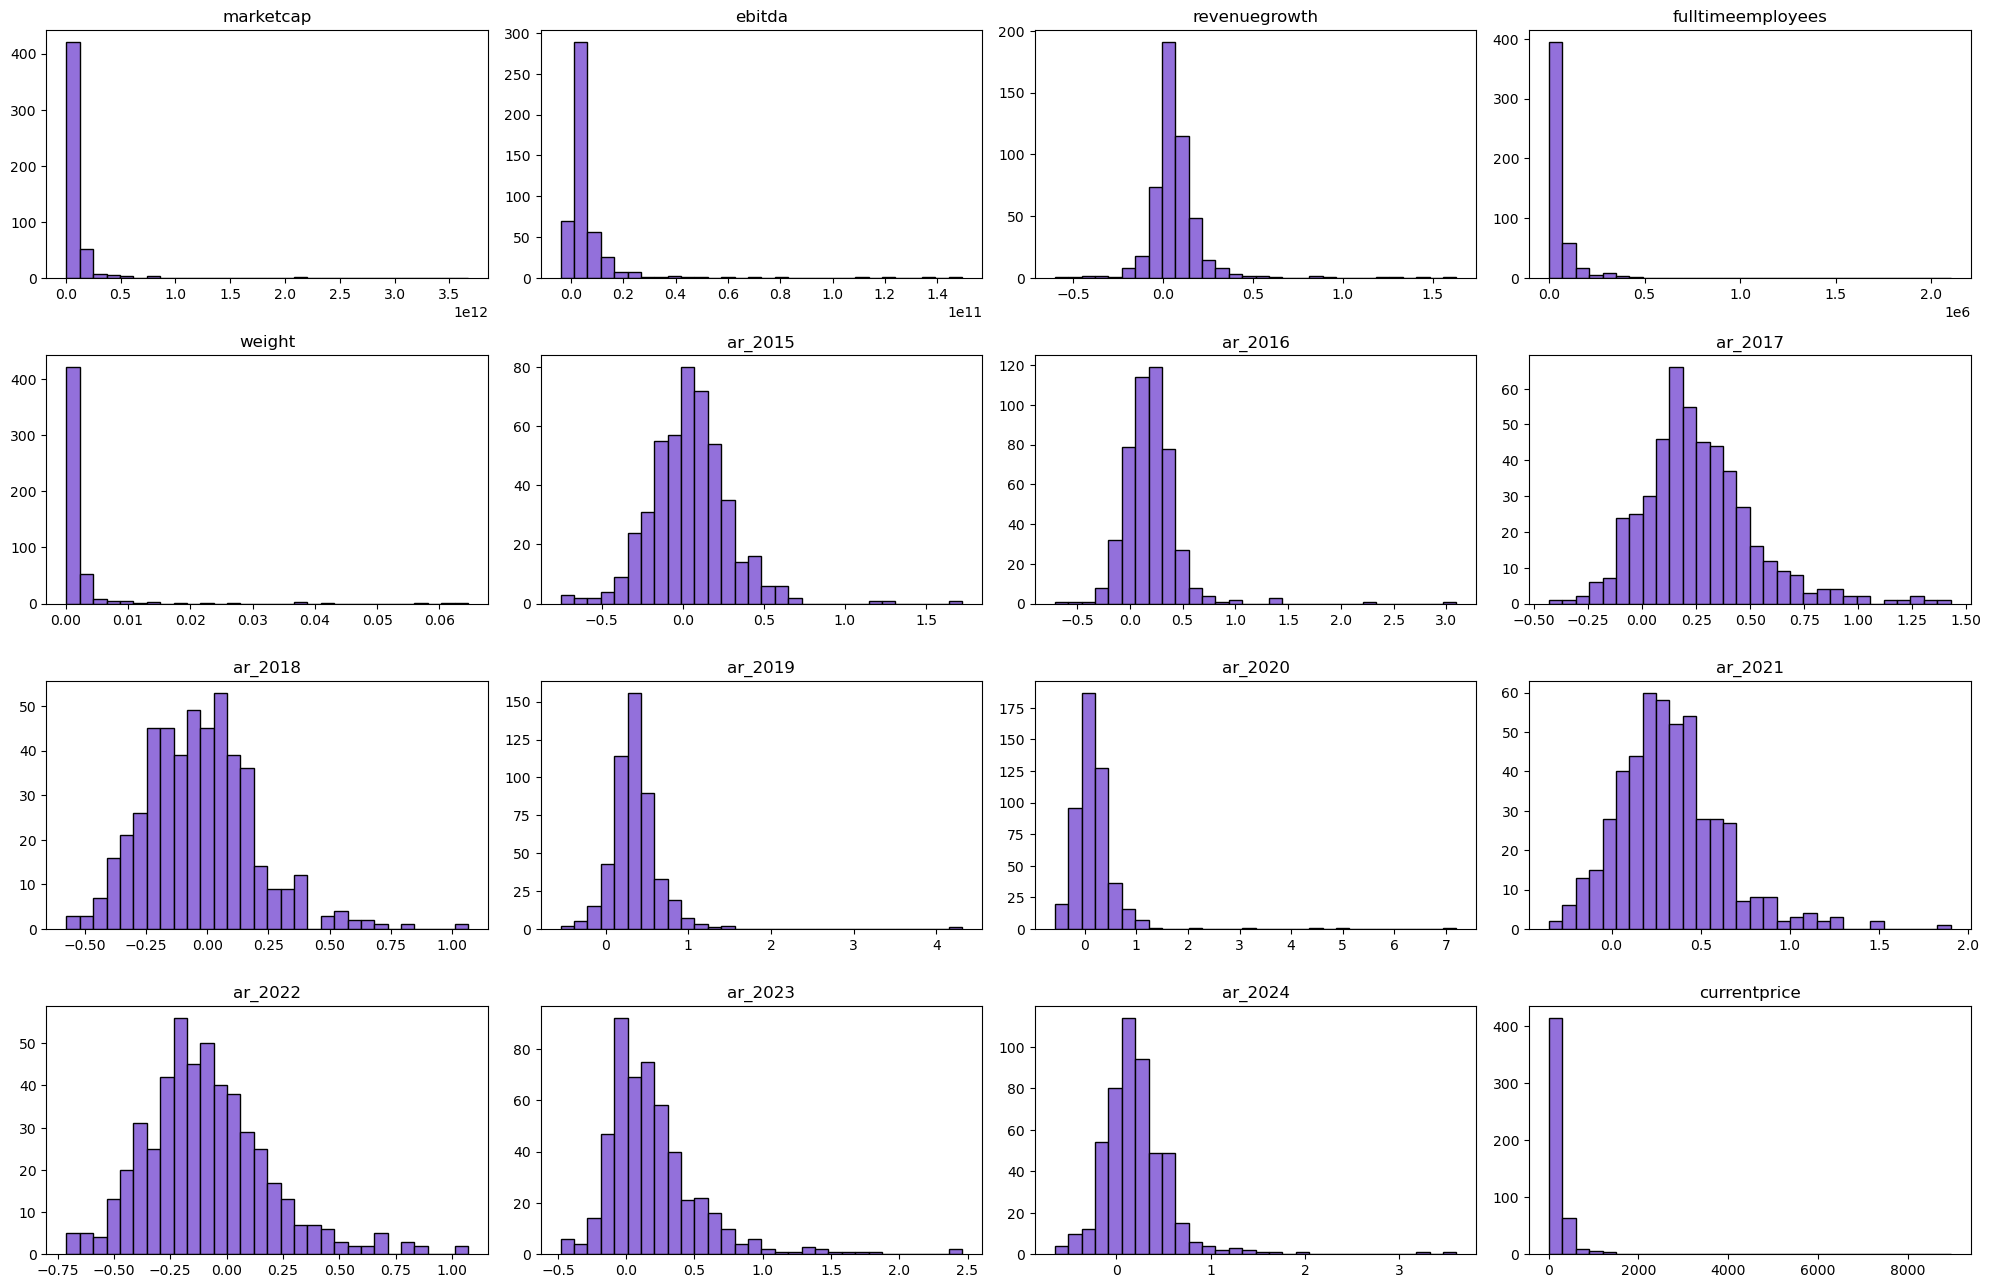

In [59]:
color = '#9370DB'

nrows, ncols = 5, 4 

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 16))

axes = axes.flatten()

for i, ax in enumerate(axes):
    if i >= len(num.columns):
        ax.set_visible(False)  # hide unesed plots
        continue
    ax.hist(num.iloc[:, i], bins=30, color=color, edgecolor='black')
    ax.set_title(num.columns[i])

plt.tight_layout()
plt.show()

<h3 style="color: #4169E1;"> 3.3 | Checking our target distribution</h3>

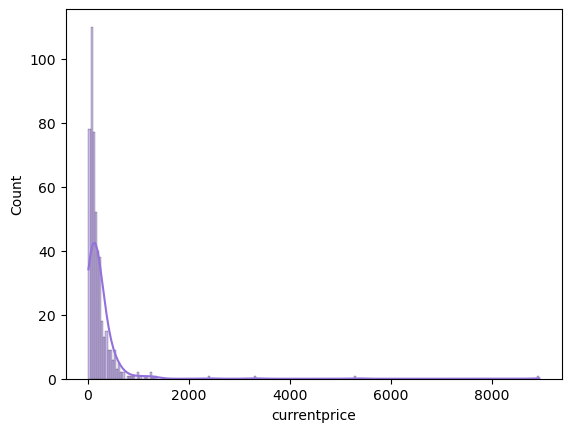

In [60]:
# Without the filter 650.000 and taking out the outliers. 
sns.histplot(definitive["currentprice"], color=color, kde=True);

(0.0, 2100.0)

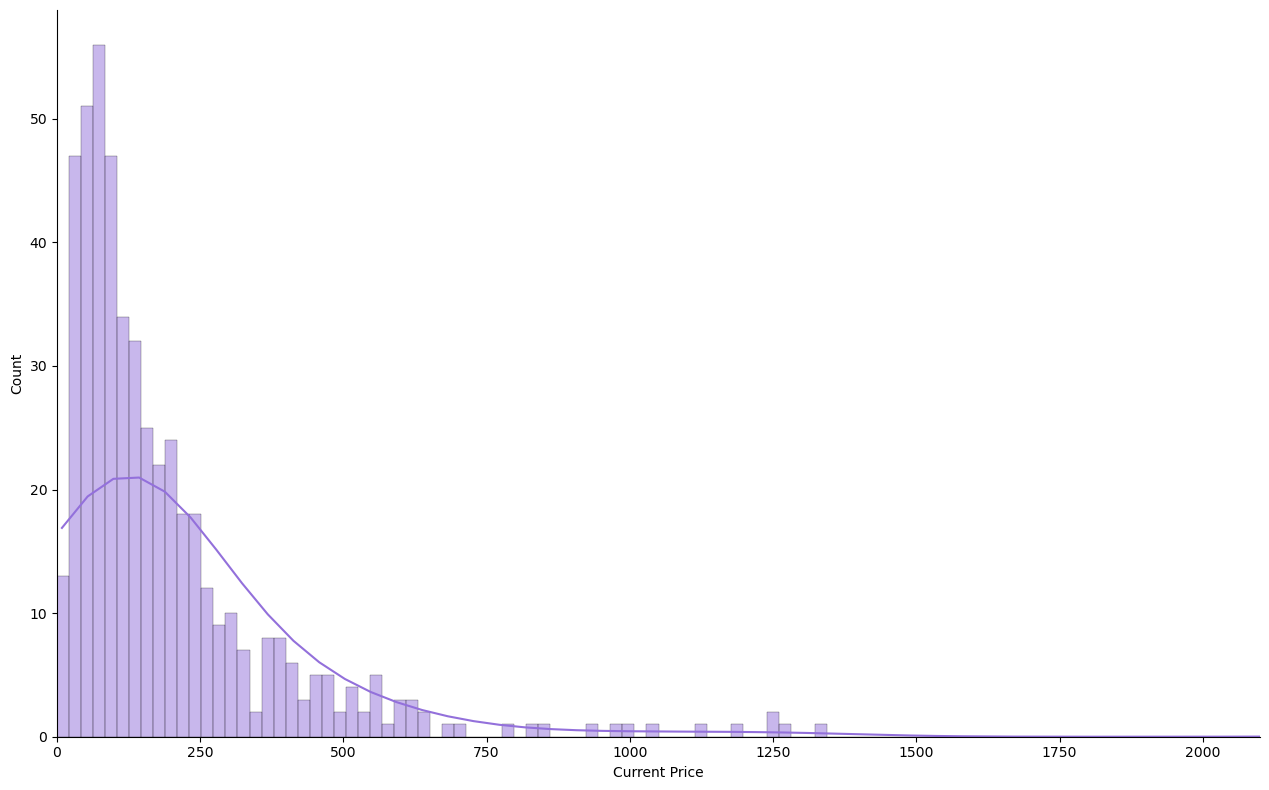

In [61]:
d2 = sns.displot(data=definitive, x='currentprice', kde=True, height=8, aspect=1.6, bins=100, binrange=(0, 2100), color='mediumpurple')
d2.set(xlabel='Current Price')
plt.xlim(0, 2100)

In [ ]:
#pearson 
num.corrwith(definitive['currentprice']).sort_values(ascending=False)

In [ ]:
#Spearman
num.corrwith(df['currentprice'], method='spearman').sort_values(ascending=False)[:5]

<h3 style="color: #4169E1;">3.4 | Checking Outliers </h3>

In [ ]:
color = '#9370DB'

# grid size
nrows, ncols = 5, 4 

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 16))

axes = axes.flatten()

for i, ax in enumerate(axes):
    if i >= len(num.columns):
        ax.set_visible(False)
        continue
    ax.boxplot(num.iloc[:, i].dropna(), vert=False, patch_artist=True, 
               boxprops=dict(facecolor=color, color='black'), 
               medianprops=dict(color='yellow'), whiskerprops=dict(color='black'), 
               capprops=dict(color='black'), flierprops=dict(marker='o', color='red', markersize=5))
    ax.set_title(num.columns[i], fontsize=10)
    ax.tick_params(axis='x', labelsize=8)

plt.tight_layout()
plt.show()

<h3 style="color: #4169E1;">3.5 | Looking for Correlations </h3>

In [ ]:
num_corr = num.corr()
num_corr

In [ ]:
# Correlation Matrix-Heatmap Plot
mask = np.zeros_like(num_corr)
mask[np.triu_indices_from(mask)] = True 
f, ax = plt.subplots(figsize=(20, 10))
sns.set(font_scale=1.5)

ax = sns.heatmap(num_corr, mask=mask, annot=True, annot_kws={"size": 12}, linewidths=.5, cmap="BuPu", fmt=".2f", ax=ax) # round to 2 decimal places
ax.set_title("Correlation Heatmap", fontsize=20) 

In [ ]:
# Plotting scatter plots for each numerical column against 'currentprice' to visualize their relationships
for col in num.columns:
    plt.figure(figsize=(5, 5))
    plt.title('Scatter plot of price vs ' + col)
    sns.scatterplot(data=definitive, x=col, y='currentprice')
    plt.show()

We will use **one-way ANOVA** to determine if there is a statistically significant difference in **stock price** based on **sector**.

#### Define Hypotheses
- **Null Hypothesis (H₀)**: There is no difference in mean stock prices between sectors such as at **Technolgies**, **Industrials**, and **Finance** companies.
- **Alternative Hypothesis (H₁)**: At least one group mean is different.

In [ ]:
# Not done. 
# Extract salaries for Data Scientists by company size
df_small = df[(df["job_title"] == "Data Scientist") & (df["company_size"] == "Small")]["salary_in_usd"]
df_medium = df[(df["job_title"] == "Data Scientist") & (df["company_size"] == "Medium")]["salary_in_usd"]
df_large = df[(df["job_title"] == "Data Scientist") & (df["company_size"] == "Large")]["salary_in_usd"]

In [ ]:
# Perform One-Way ANOVA
f_stat, p_value = st.f_oneway(df_small, df_medium, df_large)
print(f"F-Statistic: {f_stat:.2f}")
print(f"P-Value: {p_value:.4f}")
print()

# Significance level
alpha = 0.05

# Decision-Making
if p_value > alpha:
    print("Fail to Reject the Null Hypothesis: Company size has no significant impact on data scientist salaries.")
else:
    print("Reject the Null Hypothesis: There is a significant difference in salaries based on company size.")

<h2 style="color: #9370DB;"> 04 | Data Processing </h2>

<h3 style="color: #4169E1;"> 4.1 | X-Y Split</h3>

<h3 style="color: #4169E1;"> 4.2 | Selecting the Model</h3>

<h4 style="color: #00BFFF;"> 4.2.1 | Selecting Model: Linear Regression </h4>

<h4 style="color: #00BFFF;"> 4.2.2 | Selecting Model: Ridge Regression </h4>

<h4 style="color: #00BFFF;"> 4.2.3 | Selecting Model: Lasso Regression </h4>

<h4 style="color: #00BFFF;"> 4.2.4 | Selecting Model: Decision Tree Regression </h4>

<h4 style="color: #00BFFF;"> 4.2.5 | Selecting Model: KNN Regression </h4>

<h4 style="color: #00BFFF;"> 4.2.6 | Selecting Model: XGBoost Regression </h4>

<h3 style="color: #4169E1;"> 4.3 | Final Comparision</h3>

<h2 style="color: #9370DB;"> 05 | Improving Model </h2>

<h3 style="color: #4169E1;"> 5.1 | Normalization with MinMaxScaler</h3>

<h3 style="color: #4169E1;"> 5.2 | Standardization with StandardScaler</h3>

<h3 style="color: #4169E1;"> 5.3 | Normzalization with Long Transform</h3>

<h3 style="color: #4169E1;"> 5.4 | Feature Engineering </h3>

<h2 style="color: #9370DB;"> 06 | Reporting </h2>